<a href="https://colab.research.google.com/github/philipp-hellwig/human-action-classification/blob/main/Group_16_DLiP_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

In [ ]:
!unrar x /content/hmdb51_org.rar


UNRAR 6.11 beta 1 freeware      Copyright (c) 1993-2022 Alexander Roshal


Extracting from /content/hmdb51_org.rar

Extracting  shoot_gun.rar                                                  0%  1%  2%  OK 
Extracting  sit.rar                                                        2%  3%  4%  5%  6%  OK 
Extracting  situp.rar                                                      6%  7%  8%  OK 
Extracting  smile.rar                                                      8%  9%  OK 
Extracting  smoke.rar                                                      9% 10% 11% 12% 13%  OK 
Extracting  somersault.rar                                                13% 14% 15% 16%  OK 
Extracting  stand.rar                                                     16% 17% 18% 19%  OK 
Extracting  swing_baseball.rar                                            19% 2

In [1]:
%pip install opencv-python

   ---------------------------------------- 0.0/38.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/38.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/38.8 MB ? eta -:--:--
   ---------------------------------------- 0.1/38.8 MB 2.1 MB/s eta 0:00:19
   ---------------------------------------- 0.4/38.8 MB 4.1 MB/s eta 0:00:10
    --------------------------------------- 0.9/38.8 MB 6.6 MB/s eta 0:00:06
   - -------------------------------------- 1.5/38.8 MB 8.0 MB/s eta 0:00:05
   -- ------------------------------------- 2.0/38.8 MB 8.6 MB/s eta 0:00:05
   -- ------------------------------------- 2.5/38.8 MB 8.8 MB/s eta 0:00:05
   -- ------------------------------------- 2.5/38.8 MB 8.8 MB/s eta 0:00:05
   -- ------------------------------------- 2.5/38.8 MB 8.8 MB/s eta 0:00:05
   -- ------------------------------------- 2.7/38.8 MB 6.4 MB/s eta 0:00:06
   --- ------------------------------------ 3.0/38.8 MB 6.6 MB/s eta 0:00:06
   --- -------------


[notice] A new release of pip is available: 23.3.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


# Method

## Preprocessing

### Data Import

In [11]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
# Example video path (update based on extracted folder structure)
video_path_smoke = "hmdb51_org/jump/jump/50_FIRST_DATES_jump_f_nm_np1_fr_bad_3.avi"

# Open the video file
cap = cv2.VideoCapture(video_path_smoke)

vid = []
while cap.isOpened():
    ret, frame = cap.read()
    vid.append(frame)
    if not ret:
        break

In [12]:
help(np.linspace)

Help on _ArrayFunctionDispatcher in module numpy:

linspace(start, stop, num=50, endpoint=True, retstep=False, dtype=None, axis=0)
    Return evenly spaced numbers over a specified interval.

    Returns `num` evenly spaced samples, calculated over the
    interval [`start`, `stop`].

    The endpoint of the interval can optionally be excluded.

    .. versionchanged:: 1.16.0
        Non-scalar `start` and `stop` are now supported.

    .. versionchanged:: 1.20.0
        Values are rounded towards ``-inf`` instead of ``0`` when an
        integer ``dtype`` is specified. The old behavior can
        still be obtained with ``np.linspace(start, stop, num).astype(int)``

    Parameters
    ----------
    start : array_like
        The starting value of the sequence.
    stop : array_like
        The end value of the sequence, unless `endpoint` is set to False.
        In that case, the sequence consists of all but the last of ``num + 1``
        evenly spaced samples, so that `stop` is exc

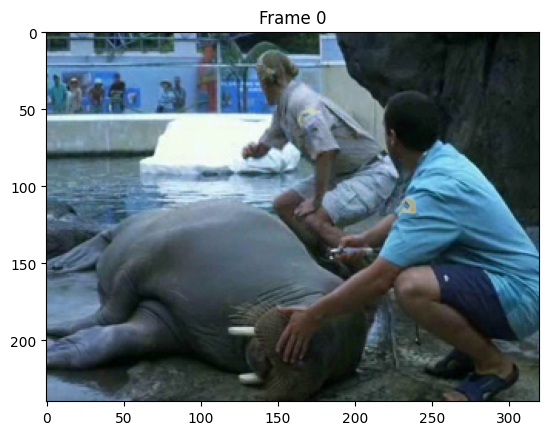

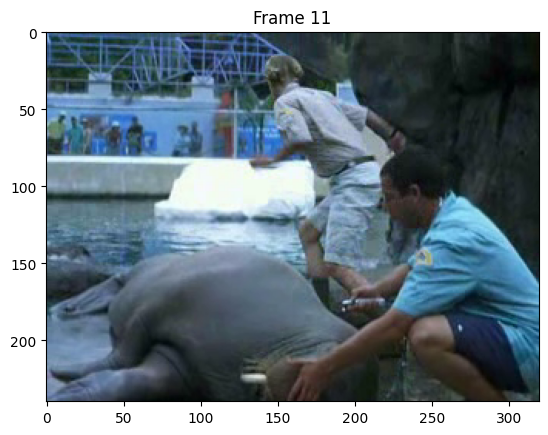

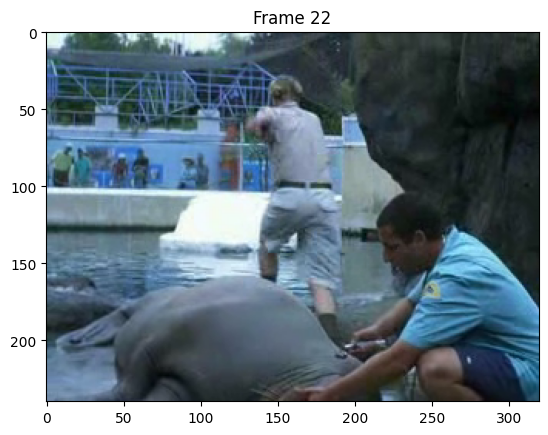

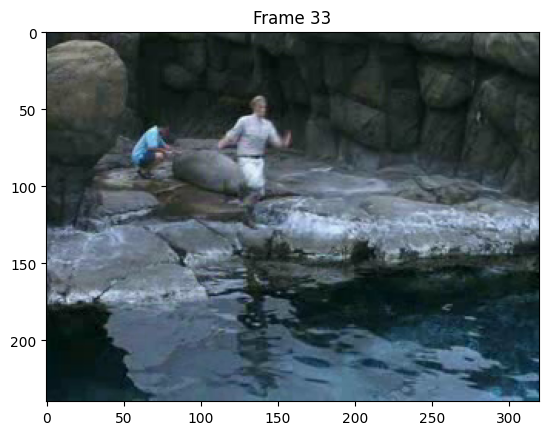

In [27]:
num_frames = 5
for i in np.linspace(0,len(vid)-1, num_frames, dtype=int):
    if vid[i] is not None:
        plt.title(f"Frame {i}")
        plt.imshow(cv2.cvtColor(vid[i], cv2.COLOR_BGR2RGB))
        plt.show()

## Creating the Model

In [ ]:
%pip install tensorflow

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras import layers

base = tf.keras.applications.VGG16(
    include_top=True,
    weights='imagenet',
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation='softmax'
)


## Training

# Results

# Discussion